## 1. Load the experiment data  using load_svmlight_file function in sklearn library.

In [11]:
%matplotlib inline 
from sklearn.externals.joblib import Memory  
from sklearn.datasets import load_svmlight_file 
import numpy as np
mem = Memory("./mycache")
@mem.cache

def get_data():
    data = load_svmlight_file("C:\\Users\\Administrator\\Desktop\\机器学习\\lab1\\australian_scale.txt")
    return data[0],data[1]

data_x,data_y = get_data() #Step1:Load the experiment data

## 2.Divide dataset into training set and validation set using train_test_split function.

In [12]:
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(data_x,data_y,test_size=0.33,random_state=42) 
#Step2:divide dataset into training set and validation set 

y_train = np.mat(y_train).T #shape y_train to m_train*1
y_valid = np.mat(y_valid).T #shape y_valid to m_valid*1

## 3.Initialize SVM model parameters randomly.

In [13]:
w = np.mat(np.random.random([x_train.shape[1],1]))*2-1
b = np.random.random()*2-1
#Step3:Initialize linear model parameters randomly range(-1,1)

## 4.Choose loss function and derivation.

In [14]:
#Step4:Choose loss function and derivation.

$$ min_{w,b}\quad f(w,b):\frac{||w||^2}{2}+C\sum_{i=1}^N max(0,1-y_i (w^T x_i +b))  $$

\begin{align}
\frac{\partial f（w,b）}{\partial w}&=w-CX^Ty \qquad 1-y_i(w^Tx_i+b)>=0 \\
&=w \quad \qquad \qquad 1-y_i(w^Tx_i+b)<0 
\end{align}

\begin{align}
\frac{\partial f（w,b）}{\partial b}&=-C\sum_{i=1}^Ny_i \qquad 1-y_i(w^Tx_i+b)>=0 \\
&=0 \quad \qquad \qquad 1-y_i(w^Tx_i+b)<0 
\end{align}

## 5.Linear Classification and Gradient Descent

Best Accuracy: 0.8640350877192983


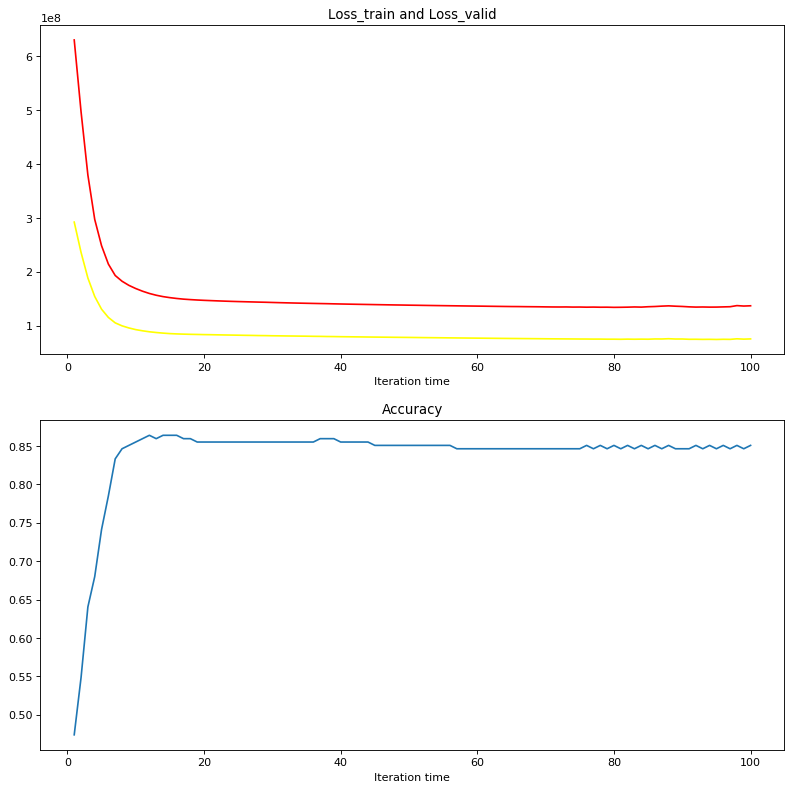

In [15]:
import matplotlib.pyplot as plt

m_train = x_train.shape[0] #number of training example
m_valid = x_valid.shape[0] #number of validation example

Loss_train = [] #Loss_train-axis
Loss_valid = [] #Loss_valid-axis
valid_right_rate = [] #valid_right_rate-axis
x = [] #x-axis:the number of iterations
best_accuracy = 0
C =1000000
learn_rate = 0.000000001 #Learning rate

for n in range(0,100):#Step9:Repeat step5 to step8 for 100 times.
    G_w = np.zeros([x_train.shape[1],1]) #Initialize G_w
    G_b = 0 #Initialize G_b
    x.append(n+1) #Update x-axis

    for n in range(0,m_train):
        result = 1 - y_train[n]*(w.T*x_train[n].T+b)
        if(result>=0):
            G_w = G_w + (w-C*x_train[n].T*y_train[n])
            G_b = G_b + (-C*y_train[n])
        elif(result<0):
            G_w = G_w + w
            G_b = G_b
    #Step5:Calculate gradient G toward loss function from all samples.
            
    D_w = -G_w
    D_b = -G_b
    #Step6:Denote the opposite direction of gradient G as D.

    w = w + learn_rate*D_w
    b = b + learn_rate*D_b
    #Step7:Update model parameters.

    threshold = 0 #Threshold

    y_fore = [] 
    for n in range(0,m_valid):
        result = x_valid[n]*w+b
        if(result>=threshold):
            y_fore.append(1)

        elif(result<threshold):
            y_fore.append(-1)
    #Calculate the forecast y
    
    r = 0 
    for n in range(0,m_valid):
        if(y_fore[n]==y_valid[n]):
            r = r+1
        else:
            r = r
    if((r/m_valid )>best_accuracy):
        best_accuracy = r/m_valid
    valid_right_rate.append(r/m_valid)
    #Calculate the right rate of fore_y
    
    Loss_train_sum = 0
    for n in range(0,m_train):
        result = 1 - y_train[n]*(w.T*x_train[n].T+b)
        if(result>=0):
            Loss_train_sum = Loss_train_sum + result
        elif(result<0):
            Loss_train_sum = Loss_train_sum
    Loss_train.append((0.5*(w.T*w) + C*Loss_train_sum)[0,0])
    
    Loss_valid_sum = 0
    for n in range(0,m_valid):
        result = 1 - y_valid[n]*(w.T*x_valid[n].T+b)
        if(result>=0):
            Loss_valid_sum = Loss_valid_sum + result
        elif(result<0):
            Loss_valid_sum = Loss_valid_sum
            
    Loss_valid.append((0.5*(w.T*w) + C*Loss_valid_sum)[0,0])
    #Step8:Get the Loss under training set and validation set.

plt.figure(figsize=(12,12),dpi=80)
f2 = plt.subplot(212)
f2.set_title("Accuracy")
f2.set_xlabel("Iteration time")
plt.plot(x,valid_right_rate)
#Drawing graph of accuracy with the number of iterations

f1 = plt.subplot(211)
plt.plot(x, Loss_train, color = 'red')
plt.plot(x, Loss_valid, color = 'yellow')
f1.set_title("Loss_train and Loss_valid")
f1.set_xlabel("Iteration time")
#Step10:Drawing graph of Loss_train and Loss_valid with the number of iterations.

print("Best Accuracy: "+ str(best_accuracy))